# Supermind Task - Crypto Keywords Extraction
###subtasks:
- Loading Data and important libraries
- Preprocessing text 
- Using spacy for pos tag and extracting noun words/phrases
- Generating embeddings for noun-corpus and crypto-corpus using transformers model - roberta
- calculating distance between noun embeddings and crypto embeddings with Cosine Similarity 
- Extracting values above threshold and mapping with keywords from nouns

In [83]:
# Importing Libraries
# !pip install transformers 

import pandas as pd
import numpy as np
import pprint
import re


import spacy 
from transformers import AutoTokenizer, TFAutoModel
from wordcloud import WordCloud 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

spacy.require_gpu()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading Data 

In [9]:
data_df = pd.read_csv('/content/data.csv')
abb_df  = pd.read_csv('/content/term_abb.csv')
def_df  = pd.read_csv('/content/term_def.csv')

print('Data dataframe memory:',data_df.info(memory_usage="deep")) # Twitter contents
print('Abb dataframe memory:',abb_df.info(memory_usage="deep")) # crypto abbreviations
print('Def dataframe memory:',def_df.info(memory_usage="deep")) # definition of crypto words



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44136 entries, 0 to 44135
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       44136 non-null  int64 
 1   content  43486 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.3 MB
Data dataframe memory: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   terms          98 non-null     object
 1   abbreviations  98 non-null     object
dtypes: object(2)
memory usage: 13.4 KB
Abb dataframe memory: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   terms        160 non-null    object
 1   definition1  160 non-null    object
 2   definition2  14 non-null     object
dtypes: object(3)

### Preprocessing Texts

In [10]:
# twitter slang words

contractions = {
"ain't": "am not / are not","aren't": "are not / am not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
"haven't": "have not","he'd": "he had / he would","he'd've": "he would have","he'll": "he shall / he will","he'll've": "he shall have / he will have","he's": "he has / he is",
"how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how has / how is","i'd": "I had / I would","i'd've": "I would have","i'll": "I shall / I will",
"i'll've": "I shall have / I will have","i'm": "I am","i've": "I have","isn't": "is not","it'd": "it had / it would","it'd've": "it would have","it'll": "it shall / it will",
"it'll've": "it shall have / it will have","it's": "it has / it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have",
"mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not",
"needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
"she'd": "she had / she would","she'd've": "she would have","she'll": "she shall / she will","she'll've": "she shall have / she will have","she's": "she has / she is",
"should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so as / so is","that'd": "that would / that had",
"that'd've": "that would have","that's": "that has / that is","there'd": "there had / there would","there'd've": "there would have","there's": "there has / there is","they'd": "they had / they would",
"they'd've": "they would have","they'll": "they shall / they will","they'll've": "they shall have / they will have","they're": "they are","they've": "they have","to've": "to have",
"wasn't": "was not","we'd": "we had / we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not",
"what'll": "what shall / what will","what'll've": "what shall have / what will have","what're": "what are","what's": "what has / what is","what've": "what have","when's": "when has / when is",
"when've": "when have","where'd": "where did","where's": "where has / where is","where've": "where have","who'll": "who shall / who will","who'll've": "who shall have / who will have",
"who's": "who has / who is","who've": "who have","why's": "why has / why is","why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have",
"wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
"you'd": "you had / you would","you'd've": "you would have","you'll": "you shall / you will","you'll've": "you shall have / you will have","you're": "you are",
"you've": "you have","nan":"bitcoin"
}

In [11]:
# Extracting tweets and joining them into a single paragraph.
# Makes preproccessing easier

texts=data_df.content.values.astype(str).tolist()
texts=','.join(texts)
texts=texts.lower()

In [12]:
texts

'hey 👋 \n\nwe re using our bot:\n\nhttps://t.me/lobster_watcher\n\nand also filtering such recommendations to select only topics worth attention.\n\n~5 people are in duty every day.,good stuff \n\ni am surprised i took so long to find this community lol,you are using a non-official one,use the one that uniswap uses: https://thegraph.com/hosted-service/subgraph/ianlapham/arbitrum-minimal,keep in mind this is a hot subgraph so it can change anytime without notice,https://twitter.com/vestafinance/status/1488194710434828288?s=21,voting with money is beyond dumb. the fact someone has 100x money doesn\'t mean they have 100x better judgement. on the contrary, after some point, they are probably checked out and too busy chilling.,nan,+,r u adjusting the gov model then?,we are just not voting often and delegating to people who know their shit,quadratic voting solves this, but needs somehow verify identity of holder.,hope,you guys never have to deal with any of this,https://www.youtube.com/watch

In [13]:
# Removal of punctuations, mail id, url links ,#,@

def clean_text(text):
    stop_words = set(stopwords.words('english'))
    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF"  u"\U0001F1E0-\U0001F1FF"  u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0" u"\U00002702-\U000027B0" u"\U000024C2-\U0001F251" u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff" u"\u2640-\u2642" u"\u2600-\u2B55" u"\u200d" u"\u23cf" u"\u23e9" u"\u231a" u"\ufe0f" u"\u3030" "]+", flags=re.UNICODE)

    txt = emoji_pattern.sub(r'', text)   # remove emojis
    txt = re.sub(r"\S*https?:\S*", "", txt) 
    txt = re.sub(r'[+=#$@~:\n?!<>"^"/\/\*...()-]',"",txt)# remove hyperlink
    txt = [w for w in txt.split() if not w in stop_words]
    txt = ' '.join(txt)
    return txt
text = clean_text(texts)


In [14]:
text

"hey using botand also filtering recommendations select topics worth attention5 people duty every day,good stuff surprised took long find community lol,you using nonofficial one,use one uniswap uses mind hot subgraph change anytime without money beyond dumb fact someone 100x money mean 100x better judgement contrary, point, probably checked busy chilling,nan,,r u adjusting gov model then,we voting often delegating people know shit,quadratic voting solves this, needs somehow verify identity holder,hope,you guys never deal never submit vision, project best,ouch,i'd argue reality downwards diagonal even, kind bell curve,idk, think small traders sit governance forums think accurate think mental model,i wanna pay 400 gas fee vote,imo active users couch governance rocket back day yes, forums mix, sure days tbh,most votes snapshot sir, gas fees all,im kinda exagerating tho, agree good mental model,thanks,thanks, guess could also deploy contract chains invested 20,is token srsly called lfg jfc

In [108]:
# creating dictionary from abbreviation dataset 

abb_dict={}
def create_dict(df):
    for key, value in zip(df.terms.astype(str),df.abbreviations.astype(str)):
        abb_dict[value.lower()]=key.lower()
    return abb_dict
crypto_abb=create_dict(abb_df)


In [16]:
# mapping abbreviations to their correponding words and slang to root words.

words=[]
def word_magic(dictionary,texts):
    txt=texts.split()
    for i in txt:
        words.append(dictionary.get(i,i))
    txt=' '.join(words)
    return txt
txt=word_magic(crypto_abb,text)
txt= word_magic(contractions,txt)

In [17]:
def corpus(df1,df2):
    crypto=df1.terms.values.astype(str).tolist()
    for i in df2.terms.values.astype(str).tolist():
        crypto.append(i)
    crypto = ' '.join(crypto)
    crypto = crypto.lower()
    return crypto

crypto_corpus=corpus(abb_df,def_df)

crypto_corpus=clean_text(crypto_corpus)
crypto_corpus


'auroracoin bitconnect inactive bitcoin cash bitcoin dash dogecoin eosio ethereum classic ether also known ethereum gridcoin litecoin coinye inactive mazacoin nano neo namecoin nxt potcoin peercoin titcoin usd coin stablecoin tether vertcoin nem stellar monero primecoin ripple verge zcash bitcoin improvement proposal automatic teller machine bitcoin enterprise ethereum alliance ethereum improvement proposal fundamental analysis moving average convergence divergence proof burn proof developer technical analysis trend analysis coordinated universal time year date address application programming interface brute force attack bitcoin address format also known bc1 addresses developers conference multisignature secure hash acronym 256bit worldwide developers conference antimoney laundering alltime high alltime low coinmarketcap decentralized autonomous initial coin offering dollar cost averaging decentralized finance distributed ledger technology token standard ethereum token standard nft non

### Spacy Pos-Tag

In [18]:
# Loading spacy model 'en_core_web_sm' for part of speech tagging

txt = txt.split(',')
doc1=[]

def pos_tag(data):
    nlp = spacy.load('en_core_web_sm',)
    for i in data:
        doc1.append(nlp(i))  
    return doc1

data1= pos_tag(txt)

In [19]:
#extracting noun - text, phrases from spacy

nouns=set()
phrases=set()
def noun_chunks(data):
    for i in data:
        phrases.update(set(chunk.text for chunk in i.noun_chunks))
        for j in i:
            if j.pos_=='NOUN':
                nouns.add(j.text)
        
    all_nouns = nouns.union(phrases)
    return all_nouns

all_nouns = list(noun_chunks(data1))

### Creating Embeddings with Bert Transformers.

In [20]:
# Loading Bert Model from Hugging face.

model     = TFAutoModel.from_pretrained('distilroberta-base')
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

Some layers from the model checkpoint at distilroberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Improvising to to reduce memory usage

In [36]:
# Due to low ram availability.I had to batch the noun corpus before feeding it to bert model
# creating batches of 72 of all_noun list of items -74572
# each batch contains approximately -1024 words

batch_nouns=[]
for i in np.array_split(all_nouns,72):
  batch_nouns.append(i.tolist())


In [38]:
# Creating embeddings of every word in a dimentions of 768

all_embed=[]
def noun_word_embeddings(data):
  for i in data:
     noun_tokens = tokenizer(i, padding=True ,max_length=512,return_tensors="tf")
     embeddings = model(**noun_tokens)['pooler_output'].numpy()
     all_embed.extend(embeddings.tolist())
  return np.array(all_embed)

noun_embeddings= noun_word_embeddings(batch_nouns)


In [39]:
# creating a single embedding for crypto corpus for similarity detection

crypto_tokens = tokenizer(crypto_corpus, padding=True ,max_length=1024,return_tensors="tf")
crypto_embeddings = model(**crypto_tokens)['pooler_output'].numpy()

### Distance Measurement 
- Cosine Similarity - similar values ranges close to 1 and independent values close to 0

In [111]:
def Key_phrases(embed1,embed2,n,thresh):
    distances = np.squeeze(cosine_similarity(embed1 , embed2))
    distance  = np.array([i for i in distances if i > thresh])
    key_phrases = [all_nouns[index] for index in distance.argsort()[-n:]]

    print(' count of Noun corpus: ', len(all_nouns))
    print(' count of distance-embeddings : ', len(distances))
    print(f" max value for n for threshold {thresh}  :", len(distance))
    return key_phrases
crypto_phrases = Key_phrases(crypto_embeddings, noun_embeddings,10,  0.98)
print(crypto_phrases)

 count of Noun corpus:  74572
 count of distance-embeddings :  74572
 max value for n for threshold 0.98  : 74572
['calcs stake consensus focal point reward ethereum classic concern bad actors', 'the writer general counsel head decentralisation venture capital fund a16z crypto', ' much beneficial crypto non fugible tokens pfps', 'smart contract exploit risk depeg risk ethereum classic insurance possible solution option', 'bndaibnethbnlink current bn tokens bancor 3 current admin poolcollection contract mints', 'ready paranoidal low level decentralisation cryptoweb3defi stablecoins', 'less safe usd coin (stablecoin) bank acc tbh', 'dao eligible fractionaliztion jullian assange x pak non fugible tokens collaboration proceeds', ' non fugible tokens bridging protocol l1 ethereum l2 starknet mastercard partners', 'active wrapper ether pair market uni v3 present coingecko token list']


### Visualization of Extracted 


(-0.5, 799.5, 799.5, -0.5)

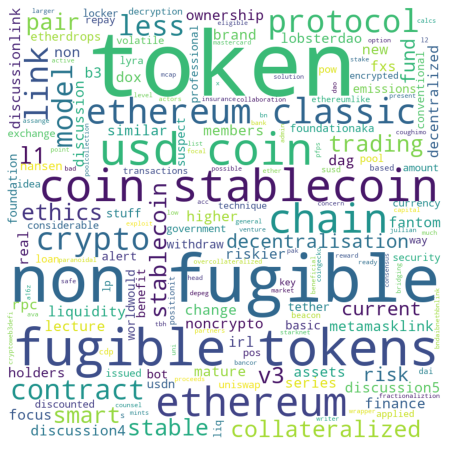

In [60]:
wordcloud_text= " ".join(crypto_phrases)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(wordcloud_text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")